# Práctico 2 - Redes en escalera avanzadas

#### Práctico 2 Aprendizaje Profundo de: Claudio Sarate - Martin Hunziker 

In [1]:
import sys
import io
import nltk
import numpy as np
import os
import pandas as pd
import sklearn
import numpy as np
import tensorflow as tf
import mlflow

from tensorflow.keras import regularizers
from IPython.display import SVG
from gensim import corpora
from nltk import word_tokenize
from nltk.corpus import stopwords
from pprint import pprint
from sklearn.preprocessing import MinMaxScaler

nltk.download(["punkt", "stopwords"]);

/home/claudio/anaconda3/envs/MachineLearning/lib/python3.7/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()
[nltk_data] Downloading package punkt to /home/claudio/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/claudio/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
in_colab = 'google.colab' in sys.modules
if in_colab:
    !pip install --upgrade pip
    !pip install --upgrade tensorflow-gpu==2.0.0
    !pip install --upgrade mlflow graphviz pydot

    print(tf.__version__)
    from google.colab import drive
    drive.mount('/content/drive')
    BASE_DIR = "/content/drive/My Drive/Colab Notebooks/Machine Learning/Aprendizaje Profundo/Data/"
else:
    BASE_DIR = "./Data/"

In [3]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

from tensorflow.keras import layers, models

## Carga de los datos

In [4]:
dataset = pd.read_csv(os.path.join(BASE_DIR, "train.csv"))

target_col = "AdoptionSpeed"
nlabels = dataset[target_col].unique().shape[0]

dataset.head(5)

,Type,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,Description,AdoptionSpeed,PID
0,2,3,299,0,1,1,7,0,1,1,2,2,2,1,1,100,41326,Nibble is a 3+ month old ball of cuteness. He ...,2,0
1,1,4,307,0,2,1,2,0,2,1,1,1,2,1,1,150,41401,"Good guard dog, very alert, active, obedience ...",2,3
2,1,1,307,0,1,1,0,0,2,1,2,2,2,1,1,0,41326,This handsome yet cute boy is up for adoption....,2,4
3,2,3,266,0,2,5,6,0,2,1,2,2,2,1,1,0,41326,This is a stray kitten that came to my house. ...,2,5
4,2,12,264,264,1,1,0,0,2,3,2,2,3,1,1,300,41326,anyone within the area of ipoh or taiping who ...,1,6


## Preproceso del texto para agregarlo como feature (manejo de secuencias)

A diferencia del práctico anterior, en este caso es necesario utilizar el texto como feature extra. Pueden luego agregarlo a una red recurrente o convolucional y concatenar su salida a los atributos "escalares" (como "raza" o "género").

A continuación les mostraremos los pasos a seguir para ello. La descripción detallada de para que sirve cada paso se encuentra disponible en el [notebook 3](./3_cnns.ipynb).

### Tokenización

In [5]:
SW = set(stopwords.words("english"))


def tokenize_description(description):
    return [
        w.lower()
        for w in word_tokenize(description, language="english")
        if w.lower() not in SW
    ]


# Fill the null values with the empty string to avoid errors with NLTK tokenization
dataset["TokenizedDescription"] = (
    dataset["Description"].fillna(value="").apply(tokenize_description)
)

#### Tamaño de las descripciones

Un punto importante a tener en cuenta es que las descripciones tienen tamaño variable, y esto no es compatible con los algoritmos de aprendizaje automático. Por lo que hay que llevar las secuencias a un tamaño uniforme.

Para definir dicho tamaño uniforme, es útil mirar qué tamaños mínimos, máximos y medios manejan las descripciones y a partir de esto establecer el tamaño máximo de la secuencia.

In [6]:
pprint(dataset["TokenizedDescription"].apply(len).describe())

count    10582.000000
mean        44.419486
std         48.465910
min          0.000000
25%         16.000000
50%         31.000000
75%         55.000000
max        803.000000
Name: TokenizedDescription, dtype: float64


Vemos que más del 75% de las secuencias tienen 55 palabras o menos. Esto es un buen punto de partida, así que podemos establecer el tamaño máximo de las secuencia en 55 palabras.

In [7]:
MAX_SEQUENCE_LEN = 55

## Vocabulario

In [8]:
vocabulary = corpora.Dictionary(dataset["TokenizedDescription"])
vocabulary.filter_extremes(no_below=1, no_above=1.0, keep_n=10000)

## Word Embeddings (GloVe)

In [9]:
embeddings_index = {}

with open(BASE_DIR + "glove.6B.100d.txt", "r") as fh:
    for line in fh:
        values = line.split()
        word = values[0]
        if (
            word in vocabulary.token2id
        ):  # Only use the embeddings of words in our vocabulary
            coefs = np.asarray(values[1:], dtype="float32")
            embeddings_index[word] = coefs

print("Found {} word vectors.".format(len(embeddings_index)))

Found 7897 word vectors.


## Creación de los datasets

Similar al práctico anterior, tendremos datos que serán "one-hot-encoded", otros serán "embeddings" y otros serán numéricos.

El caso particular del texto es que será tratado como una secuencia de embeddings, y dichos embeddings no serán entrenados en conjunto con la red, sino que serán tomados de un modelo "pre-entrenado". En este caso utilizamos GloVe, pero podríamos haber utilizado otro modelo (e.g. FastText).

In [10]:
# It's important to always use the same one-hot length
one_hot_columns = {
    one_hot_col: dataset[one_hot_col].max()
    for one_hot_col in [
        "Type",
        "Gender",
        "MaturitySize",
        "FurLength",
        "Vaccinated",
        "Dewormed",
        "Sterilized",
        "Health",
    ]
}
embedded_columns = {
    embedded_col: dataset[embedded_col].max() + 1
    for embedded_col in ["Breed1", "Breed2", "Color1", "Color2", "Color3"]
}
numeric_columns = ["Age", "Fee"]

## Generador del conjunto de datos

Dada la naturaleza de los datos de texto, y que estos representan una secuencia de datos (que se da luego a una red recurrente o convolucional), en este caso no crearemos los datasets de antemano, sino que los generaremos a medida que el algoritmo de entrenamiento los pida. 

En particular, es porque las secuencias de texto pueden no tener el mismo tamaño (las oraciones tienen diferente cantidad de palabras), pero para que los modelos de redes las acepten, necesitamos rellenarlas (*padding*) de manera que todas tengan el mismo tamaño.

En este paso también vamos a truncar aquellas secuencias de descripciones con más de `MAX_SEQUENCE_LEN` palabras, de manera que al hacer uso de `padded_batch` no lance un error al encontrarse con secuencias de tamaño mayor.

In [11]:
# Normalizamos las vareiables numéricas
dataset[numeric_columns] = sklearn.preprocessing.minmax_scale(
    dataset[numeric_columns], feature_range=(0, 1), axis=0
)

In [12]:
def dataset_generator(ds, test_data=False):
    for _, row in ds.iterrows():
        instance = {}

        direct_features = []
        # One hot encoded features
        instance["direct_features"] = np.hstack(
            [
                tf.keras.utils.to_categorical(row[one_hot_col] - 1, max_value)
                for one_hot_col, max_value in one_hot_columns.items()
            ]
        )

        # Numeric features (should be normalized beforehand)
        for n_col in numeric_columns:
            instance[n_col] = [row[n_col]]

        #   for n_col in numeric_columns:
        #       instance[n_col] = tf.keras.utils.normalize(ds[n_col].values.reshape(-1,1))
        #   for n_col in numeric_columns:
        #       instance[n_col] = np.hstack(tf.keras.utils.normalize(df[n_col].values))

        # Embedded features
        for embedded_col in embedded_columns:
            instance[embedded_col] = [row[embedded_col]]

        # Document to indices for text data, truncated at MAX_SEQUENCE_LEN words
        instance["description"] = vocabulary.doc2idx(
            row["TokenizedDescription"], unknown_word_index=len(vocabulary)
        )[:MAX_SEQUENCE_LEN]

        # One hot encoded target for categorical crossentropy
        if not test_data:
            target = tf.keras.utils.to_categorical(row[target_col], nlabels)
            yield instance, target
        else:
            yield instance

In [13]:
# Set output types of the generator (for numeric types check the type is valid)
instance_types = {
    "direct_features": tf.float32,
    "description": tf.int32
}

for embedded_col in embedded_columns:
    instance_types[embedded_col] = tf.int32

for n_col in numeric_columns:
    instance_types[n_col] = tf.float32

tf_dataset = tf.data.Dataset.from_generator(
    lambda: dataset_generator(dataset),
    output_types=(instance_types, tf.int32)
)

for data, target in tf_dataset.take(2):
    pprint(data)
    pprint(target)
    print()

{'Age': <tf.Tensor: id=49, shape=(1,), dtype=float32, numpy=array([0.01176471], dtype=float32)>,
 'Breed1': <tf.Tensor: id=50, shape=(1,), dtype=int32, numpy=array([299], dtype=int32)>,
 'Breed2': <tf.Tensor: id=51, shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>,
 'Color1': <tf.Tensor: id=52, shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>,
 'Color2': <tf.Tensor: id=53, shape=(1,), dtype=int32, numpy=array([7], dtype=int32)>,
 'Color3': <tf.Tensor: id=54, shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>,
 'Fee': <tf.Tensor: id=55, shape=(1,), dtype=float32, numpy=array([0.03333334], dtype=float32)>,
 'description': <tf.Tensor: id=56, shape=(42,), dtype=int32, numpy=
array([23,  2, 20, 24,  4, 10,  1, 11, 26,  1, 27,  9,  6, 21,  3,  8, 15,
       22, 33,  7, 13, 30,  1, 29, 18, 17,  1, 12, 31, 14,  5,  6, 16,  1,
       19, 28, 25, 32, 23,  0,  5,  1], dtype=int32)>,
 'direct_features': <tf.Tensor: id=57, shape=(24,), dtype=float32, numpy=
array([0., 1., 1., 0.,

## Datos de entrenamiento y validación

Ya generado el conjunto de datos base, tenemos que dividirlo en entrenamiento y validación. Además, como vamos a utilizar algunos datos que forman secuencias, los lotes (*batches*) de datos deben estar "rellenados" (*padded_batch*). 

Si bien rellenaremos "todos" los atributos, en la práctica el único que efectivamente se rellenará es el de *description* pues es el único con tamaños distintos.

In [14]:
TRAIN_SIZE = int(dataset.shape[0] * 0.8)
DEV_SIZE = dataset.shape[0] - TRAIN_SIZE
BATCH_SIZE = 128

shuffled_dataset = tf_dataset.shuffle(TRAIN_SIZE + DEV_SIZE, seed=42)

# Pad the datasets to the max value for all the "non sequence" features
padding_shapes = (
    {
        k: [-1]
        for k in ["direct_features"]
        + list(embedded_columns.keys())
        + list([(numeric_columns)[0]])
        + list([(numeric_columns)[1]])
    },
    [-1],
)

# Pad to MAX_SEQUENCE_LEN for sequence features
padding_shapes[0]["description"] = [MAX_SEQUENCE_LEN]

# Pad values are irrelevant for non padded data
padding_values = ({k: 0 for k in list(embedded_columns.keys())}, 0)

# Padding value for direct features should be a float
padding_values[0]["direct_features"] = np.float32(0)

# Padding value for sequential features is the vocabulary length + 1
padding_values[0]["description"] = len(vocabulary) + 1

# Agregamos para las columnas numéricas
padding_values[0][numeric_columns[0]] = np.float32(0)
padding_values[0][numeric_columns[1]] = np.float32(0)


train_dataset = shuffled_dataset.skip(DEV_SIZE).padded_batch(
    BATCH_SIZE, padded_shapes=padding_shapes, padding_values=padding_values
)

dev_dataset = shuffled_dataset.take(DEV_SIZE).padded_batch(
    BATCH_SIZE, padded_shapes=padding_shapes, padding_values=padding_values
)

#train_dataset = tf_dataset.skip(DEV_SIZE).shuffle(TRAIN_SIZE, seed=41231)\
#    .batch(BATCH_SIZE)

#dev_dataset = tf_dataset.take(DEV_SIZE).shuffle(DEV_SIZE, seed=41231)\
#    .batch(BATCH_SIZE)

## Construyendo el modelo

Al modelo anterior tenemos que agregarle la capa que maneje los embeddings de las palabras, e inicializarla de manera acorde, podemos guiarnos por lo visto en el [notebook 3](./3_cnns.ipynb) para hacer esto.

### Matriz de embeddings de palabras

In [15]:
EMBEDDINGS_DIM = 100  # Given by the model (in this case glove.6B.100d)

embedding_matrix = np.zeros((len(vocabulary) + 2, 100))

for widx, word in vocabulary.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[widx] = embedding_vector
    else:
        # Random normal initialization for words without embeddings
        embedding_matrix[widx] = np.random.normal(size=(100,))

# Random normal initialization for unknown words
embedding_matrix[len(vocabulary)] = np.random.normal(size=(100,))

### Definiendo los inputs del modelo

Definamos los inputs del modelo, con el agregado de la capa de embeddings de palabras inicializada en `embedding_matrix`.

In [16]:
tf.keras.backend.clear_session()

# Add one input and one embedding for each embedded column
embedding_layers = []
numeric_layer = []
inputs = []
for embedded_col, max_value in embedded_columns.items():
    input_layer = tf.keras.layers.Input(shape=(1,), name=embedded_col)
    inputs.append(input_layer)
    # Define the embedding layer
    embedding_size = int(max_value / 4)
    embedding_layers.append(
        tf.squeeze(
            tf.keras.layers.Embedding(input_dim=max_value, output_dim=embedding_size)(
                input_layer
            ),
            axis=-2,
        )
    )
    print(
        "Adding embedding of size {} for layer {}".format(embedding_size, embedded_col)
    )

# Add the direct features already calculated
direct_features_input = tf.keras.layers.Input(
    shape=(sum(one_hot_columns.values()),), name="direct_features"
)
inputs.append(direct_features_input)

# Add numeric columns
numerical_inputs = [
    tf.keras.layers.Input(shape=(1,), name=n_col) for n_col in numeric_columns
]
inputs += numerical_inputs

# Word embedding layer
description_input = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LEN,), name="description")
inputs.append(description_input)

word_embeddings_layer = tf.keras.layers.Embedding(
    embedding_matrix.shape[0],
    EMBEDDINGS_DIM,
    weights=[embedding_matrix],
    input_length=MAX_SEQUENCE_LEN,
    trainable=False,
    name="word_embedding",
)(description_input)

Adding embedding of size 77 for layer Breed1
Adding embedding of size 77 for layer Breed2
Adding embedding of size 2 for layer Color1
Adding embedding of size 2 for layer Color2
Adding embedding of size 2 for layer Color3


### Definiendo la red que trabajará con el texto

Antes de generar el *feature map* final entre los inputs y las clases, tenemos que generar el *feature map* de las secuencias de texto. 


In [17]:
## TODO: Create a NN (CNN or RNN) for the description input (replace the next)

# Se utilizaran SimpleRNN, GRU y LSTM para ver diferencias de performance

DESCRIPTION_FEATURES_LAYER_SIZE = 512

# SimpleRNN

#description_features = tf.keras.layers.SimpleRNN(units=256,
#                                                 activation='tanh',
#                                                 use_bias=True,
#                                                 kernel_initializer='glorot_uniform',
#                                                 recurrent_initializer='orthogonal',
#                                                 bias_initializer='zeros',
#                                                 dropout=0.2,
#                                                 recurrent_dropout=0.2) (word_embeddings_layer)

# GRU

#description_features = tf.keras.layers.GRU(units=256,
#                                           activation='tanh',
#                                           recurrent_activation='sigmoid',
#                                           use_bias=True,
#                                           kernel_initializer='glorot_uniform',
#                                           recurrent_initializer='orthogonal',
#                                           bias_initializer='zeros',
#                                           dropout=0.2,
#                                           recurrent_dropout=0.2,
#                                           implementation=2,
#                                           return_sequences=False,
#                                           return_state=False) (word_embeddings_layer)

# LSTM

description_features = tf.keras.layers.LSTM(units=256,
                                            activation='tanh',
                                            recurrent_activation='sigmoid',
                                            use_bias=True,
                                            kernel_initializer='glorot_uniform',
                                            recurrent_initializer='orthogonal',
                                            bias_initializer='zeros',
                                            unit_forget_bias=True,
                                            dropout=0.2,
                                            recurrent_dropout=0.2,
                                            implementation=2,
                                            return_sequences=False,
                                            return_state=False) (word_embeddings_layer)

description_features = tf.keras.layers.Dense(
    units=DESCRIPTION_FEATURES_LAYER_SIZE,
    activation="relu",
    name="description_features",
)(description_features)

### Definiendo el *feature map* final de la red

Ahora que tenemos nuestra representación de las descripciones, pasamos a combinarlo con los demás features en la última parte de nuestra red.

In [18]:
HIDDEN_LAYER_SIZE = 128

feature_map = tf.keras.layers.Concatenate(name="feature_map")(
    embedding_layers + numerical_inputs + [description_features, direct_features_input]
)

hidden_layer = tf.keras.layers.Dense(
    HIDDEN_LAYER_SIZE, activation="relu", kernel_regularizer=regularizers.l2(0.001)
)(feature_map)
hidden_layer = tf.keras.layers.BatchNormalization()(hidden_layer)
hidden_layer = tf.keras.layers.Dropout(0.3)(hidden_layer)
hidden_layer = tf.keras.layers.Dense(
    HIDDEN_LAYER_SIZE / 2, activation="relu", kernel_regularizer=regularizers.l2(0.001)
)(hidden_layer)
hidden_layer = tf.keras.layers.BatchNormalization()(hidden_layer)
hidden_layer = tf.keras.layers.Dropout(0.3)(hidden_layer)

output_layer = tf.keras.layers.Dense(nlabels, activation="softmax", name="output")(
    hidden_layer
)

model = tf.keras.models.Model(
    inputs=inputs, outputs=[output_layer], name="LSTM"
)

### Compilando y visualizando el modelo

In [19]:
model.compile(loss="categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
model.summary()

Model: "LSTM"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
description (InputLayer)        [(None, 55)]         0                                            
__________________________________________________________________________________________________
Breed1 (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
Breed2 (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
Color1 (InputLayer)             [(None, 1)]          0                                            
_______________________________________________________________________________________________

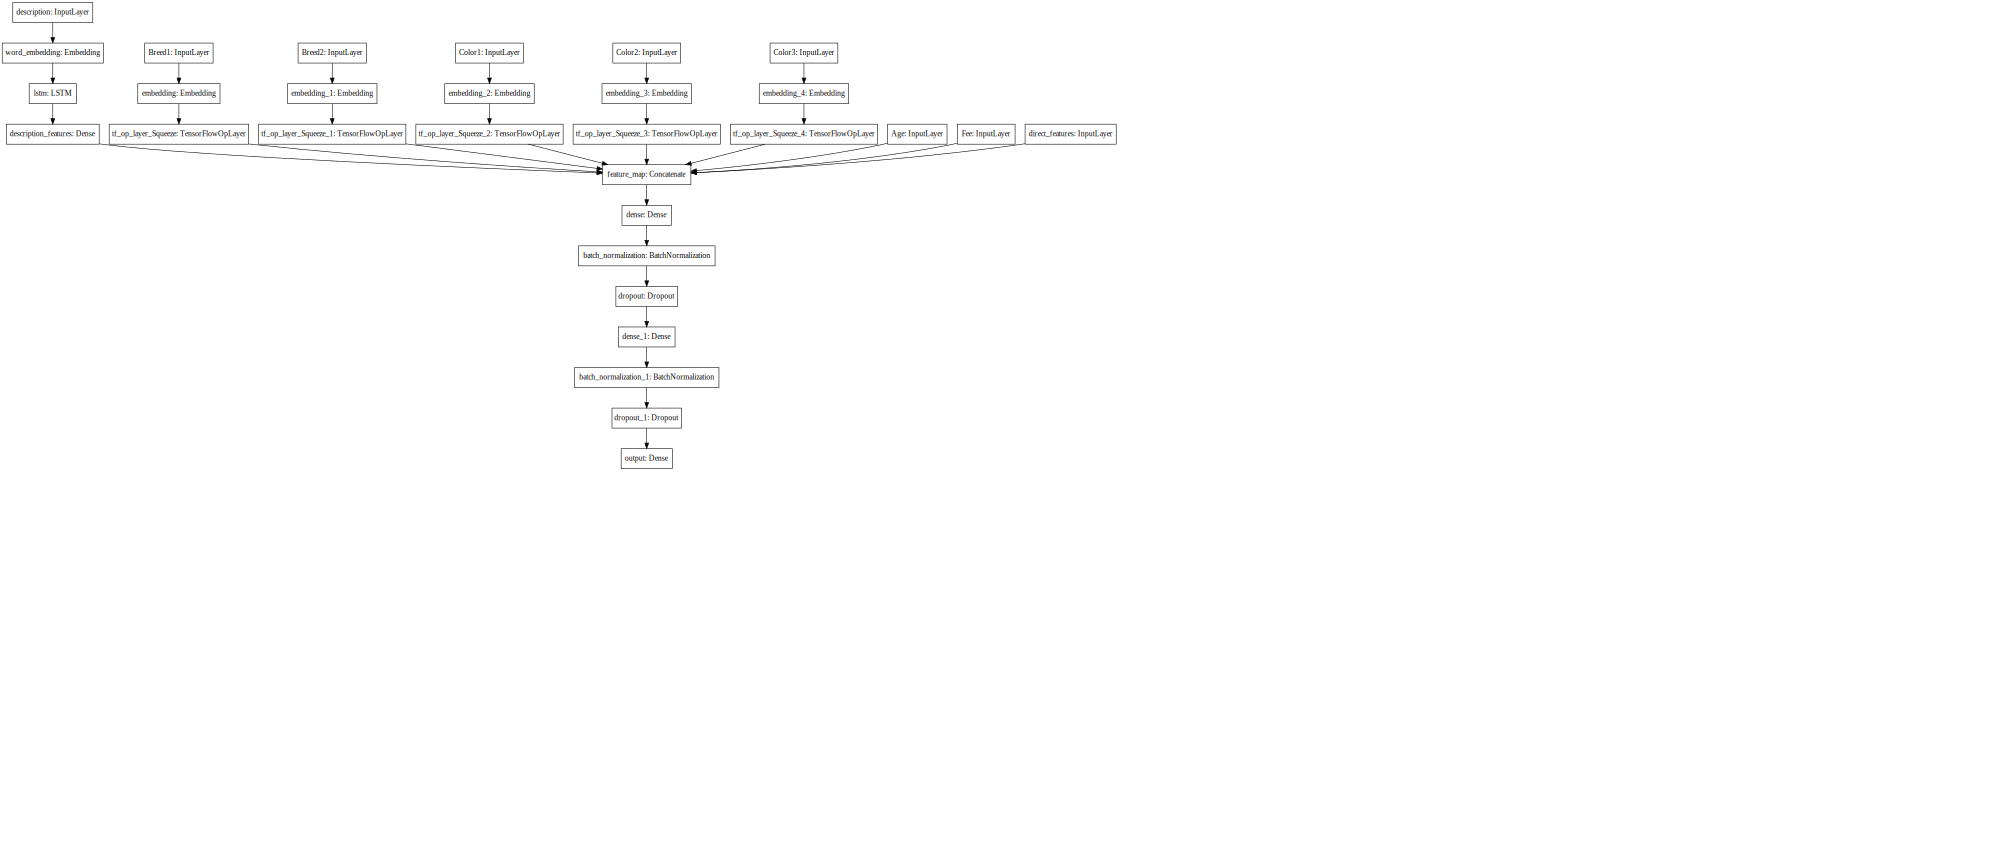

In [20]:
SVG(tf.keras.utils.model_to_dot(model, dpi=40).create(prog="dot", format="svg"))

## Entrenando el modelo

Para entrenar el modelo es igual al caso anterior, ya generados el conjunto de datos correspondiente. Lo entrenamos con ayuda de `mlflow`.

In [21]:
import mlflow

mlflow.set_experiment('awesome_advanced_approach')

with mlflow.start_run(nested=True):
    # Log model hiperparameters first
    mlflow.log_param('description_features_layer_size', DESCRIPTION_FEATURES_LAYER_SIZE)
    mlflow.log_param('hidden_layer_size', HIDDEN_LAYER_SIZE)
    mlflow.log_param('embedded_columns', embedded_columns)
    mlflow.log_param('one_hot_columns', one_hot_columns)
    mlflow.log_param('numerical_columns', numeric_columns)
    
    # Train
    epochs = 30
    history = model.fit(train_dataset, epochs=epochs)
    
    # Evaluate
    loss, accuracy = model.evaluate(dev_dataset, verbose=0)
    print("\n*** Validation loss: {} - accuracy: {}".format(loss, accuracy))
    mlflow.log_metric('epochs', epochs)
    mlflow.log_metric('train_loss', history.history["loss"][-1])
    mlflow.log_metric('train_accuracy', history.history["accuracy"][-1])
    mlflow.log_metric('validation_loss', loss)
    mlflow.log_metric('validation_accuracy', accuracy)

Epoch 1/30
67/67 [==============================] - 46s 685ms/step - loss: 2.2976 - accuracy: 0.2426
Epoch 2/30
67/67 [==============================] - 40s 595ms/step - loss: 1.9797 - accuracy: 0.2937
Epoch 3/30
67/67 [==============================] - 38s 574ms/step - loss: 1.8550 - accuracy: 0.3168
Epoch 4/30
67/67 [==============================] - 39s 579ms/step - loss: 1.7739 - accuracy: 0.3314
Epoch 5/30
67/67 [==============================] - 38s 574ms/step - loss: 1.7224 - accuracy: 0.3279
Epoch 6/30
67/67 [==============================] - 40s 592ms/step - loss: 1.6672 - accuracy: 0.3435
Epoch 7/30
67/67 [==============================] - 39s 583ms/step - loss: 1.6274 - accuracy: 0.3518
Epoch 8/30
67/67 [==============================] - 38s 575ms/step - loss: 1.6064 - accuracy: 0.3491
Epoch 9/30
67/67 [==============================] - 38s 574ms/step - loss: 1.5650 - accuracy: 0.3650
Epoch 10/30
67/67 [==============================] - 39s 582ms/step - loss: 1.5460 - accura

## Evaluando el modelo sobre los datos de evaluación para la competencia

Una vez que tenemos definido nuestro modelo, el último paso es ponerlo a prueba en los datos de evaluación para generar un archivo para enviar a la competencia Kaggle.

Comenzamos cargando el conjunto de datos.

In [22]:
test_dataset = pd.read_csv(os.path.join(BASE_DIR, "test.csv"))
test_dataset.head()

,Type,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,Description,PID
0,2,1,265,0,1,1,2,0,2,2,3,3,3,1,1,0,41401,I just found it alone yesterday near my apartm...,1
1,1,1,307,0,1,2,7,0,2,2,1,1,2,1,1,0,41326,Their pregnant mother was dumped by her irresp...,2
2,1,0,307,0,2,1,2,7,2,1,2,2,2,1,6,0,41326,Siu Pak just give birth on 13/6/10 to 6puppies...,7
3,2,12,265,0,2,1,7,0,2,2,3,3,3,1,1,0,41326,"Very manja and gentle stray cat found, we woul...",9
4,2,3,264,0,2,1,2,5,3,3,1,1,2,1,1,50,41326,Kali is a super playful kitten who is on the g...,11


## Creamos el conjunto de datos para darle al modelo entrenado

In [23]:
# First tokenize the description

test_dataset["TokenizedDescription"] = (
    test_dataset["Description"].fillna(value="").apply(tokenize_description)
)

# Generate the basic TF dataset

tf_test_dataset = tf.data.Dataset.from_generator(
    lambda: dataset_generator(test_dataset, True),
    output_types=instance_types,  # It should have the same instance types
)

for data in tf_test_dataset.take(
    2
):  # The dataset only returns a data instance now (no target)
    pprint(data)
    print()

{'Age': <tf.Tensor: id=12713, shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'Breed1': <tf.Tensor: id=12714, shape=(1,), dtype=int32, numpy=array([265], dtype=int32)>,
 'Breed2': <tf.Tensor: id=12715, shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>,
 'Color1': <tf.Tensor: id=12716, shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>,
 'Color2': <tf.Tensor: id=12717, shape=(1,), dtype=int32, numpy=array([2], dtype=int32)>,
 'Color3': <tf.Tensor: id=12718, shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>,
 'Fee': <tf.Tensor: id=12719, shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'description': <tf.Tensor: id=12720, shape=(13,), dtype=int32, numpy=
array([ 116,  429, 1371,  991,  189,    1, 7873, 1043,   62,  600,  728,
          5,    1], dtype=int32)>,
 'direct_features': <tf.Tensor: id=12721, shape=(24,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 1., 1., 0., 0.

## Padding batches

In [24]:
test_data = tf_test_dataset.padded_batch(
    BATCH_SIZE, padded_shapes=padding_shapes[0], padding_values=padding_values[0]
)

## Correr el modelo

El último paso es correr el modelo sobre los datos de evaluación para conseguir las predicciones a enviar a la competencia.

In [25]:
test_dataset["AdoptionSpeed"] = model.predict(test_data).argmax(axis=1)

test_dataset.to_csv(
    BASE_DIR + "submission.csv", index=False, columns=["PID", "AdoptionSpeed"]
)